<a href="https://colab.research.google.com/github/eugeneteoh/COMP6247-Reinforcement-Online-Learning/blob/master/lab_4/rbf_2_sarsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%matplotlib inline
import gym
from gym import wrappers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import sklearn
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler


SEED = 42

sns.set()

In [8]:
env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()

In [9]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, env, num_centroids, gamma, lr):
        # Feature Preprocessing: Normalize to zero mean and unit variance
        # We use a few samples from the observation space to do this
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)
        self.featurizer = RBFSampler(gamma=gamma, n_components=num_centroids)
        self.featurizer.fit(self.scaler.transform(observation_examples))
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant", eta0=lr)
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = self.scaler.transform([state])
        featurized = self.featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
                
        # TODO: Implement this!
        if a is not None:
            prediction = self.models[a].predict([self.featurize_state(s)])
            return prediction[0]
        
        else:
            predictions = np.array([self.models[i].predict([self.featurize_state(s)]) for i in range(env.action_space.n)])
            return predictions.reshape(-1)
            
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        # TODO: Implement this!
        self.models[a].partial_fit([self.featurize_state(s)], [y])

In [10]:
# env.render()

# Some initializations
#
n_states = 40
episodes = 500
initial_lr = 0.5
min_lr = 0.005
gamma = 0.99
max_steps = 1000
epsilon = 0.05
env = env.unwrapped
env.seed(SEED)
np.random.seed(SEED)

J_list = [5, 10, 15, 20, 50]
num_runs = 3
ep_steps = np.zeros((len(J_list), num_runs, episodes))
q_functions = np.empty((len(J_list), num_runs), dtype=object)
for i, J in enumerate(J_list):
    for run in range(num_runs):
        with tqdm(range(episodes)) as pbar:
            # function approximator
            q_function = Estimator(env, num_centroids=J, gamma=1.0, lr=0.01)
            q_functions[i, run] = q_function

            for episode in pbar:
                # print("Episode:", episode)
                state = env.reset() # [pos, vel]
                # alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
                steps = 0
                
                while True:
                    # env.render()

                    if np.random.uniform(low=0, high=1) < epsilon:
                        a = np.random.choice(env.action_space.n)
                    else:
                        a = np.argmax(q_function.predict(state))

                    next_state, reward, terminate,_ = env.step(a)
                    # Q function update
                    #

                    # q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
                    if terminate:
                        U_t = reward
                    else:
                        if np.random.uniform(low=0, high=1) < epsilon:
                            next_a = np.random.choice(env.action_space.n)
                        else:
                            next_a = np.argmax(q_function.predict(next_state))

                        U_t = reward + gamma * q_function.predict(next_state, next_a)

                    q_function.update(state, a, U_t)
                    
                    state = next_state
                    a = next_a

                    steps += 1

                    if terminate or steps == max_steps:
                        pbar.set_description(f"J: {J}, Run: {run}, Episode: {episode}, Length: {steps}")
                        ep_steps[i, run, episode] = steps
                        break

    env.close()
    # while True:
    #     env.render()

# Plotting

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
#@title
# got this from tabular q learning version
V = np.array([[  0.        ,   0.        ,   0.        ,   0.        ,
        -25.07081537, -37.12710627, -35.22694267, -37.31199857,
        -35.74317897, -37.79442102, -36.41600178, -36.5775167 ,
        -39.54030671, -35.33494335, -39.32082879, -37.12990181,
        -38.82287244, -35.28759171, -34.9392163 , -35.67298259,
        -34.55041844, -33.65709081, -32.86205412, -33.66471893,
        -33.50896001,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        -37.06079178, -38.81554554, -39.25956948, -37.3674919 ,
        -38.5693815 , -38.38669412, -36.66110143, -37.89616842,
        -39.71179686, -38.64270537, -38.8491021 , -39.24620022,
        -39.64882452, -40.11487294, -39.13878888, -38.45370816,
        -37.1153847 , -35.11148465, -34.95201161, -33.58783181,
        -34.33560114, -33.84120457, -31.83898983,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  -2.31575437,
        -39.00345928, -38.99085283, -30.72622284, -38.89215766,
        -39.30186473, -38.85302097, -38.10232518, -40.25746895,
        -40.03318318, -41.08983354, -41.34524272, -38.88787656,
        -39.92470233, -39.37989251, -39.02389978, -39.09894545,
        -43.24710079, -37.94695686, -38.11821867, -35.1974228 ,
        -31.96293824, -32.977068  , -32.23263512, -32.15761608,
        -31.40115273,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , -38.41414329,
        -38.99053294, -39.07652151, -38.95428763, -39.00921065,
        -39.44811192, -40.0361712 , -39.67653632, -39.65621156,
        -40.31267848, -40.1365035 , -39.4048778 , -41.8616547 ,
        -44.40769383, -43.01706993, -45.06589465, -39.09259848,
        -40.21286918, -43.67648845, -43.81756991, -36.73637159,
        -38.44200662, -34.99099783, -34.47325998, -29.94174045,
        -28.5683219 , -29.66153351,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  -1.        , -38.72551729,
        -39.45245564, -39.41224112, -39.47586651, -34.84943061,
        -39.83874101, -41.70834745, -40.26536053, -43.01686208,
        -41.73323988, -43.73028795, -47.98625991, -44.80841274,
        -41.9974682 , -50.00665135, -44.99671418, -50.07275736,
        -46.34322173, -51.03098844, -42.59314779, -37.23450359,
        -44.44952562, -33.24350258, -40.68743877, -33.74954013,
        -26.82293331, -31.51792911, -31.20327013,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  -4.61609026, -39.87563899,
        -39.80089855, -39.66280707, -40.22672459, -39.71148472,
        -38.8474384 , -41.18285043, -42.83855722, -41.91936501,
        -41.7575118 , -42.23388224, -42.3221268 , -50.44384306,
        -47.62501832, -55.67058892, -56.68932285, -49.58074644,
        -47.46690509, -47.93228583, -49.94637014, -49.76243688,
        -35.36729537, -41.58646575, -40.39391538, -39.89801909,
        -33.13870115, -30.80213803, -22.53265501, -28.23755159,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  -1.        , -39.42706583, -39.84773165,
        -39.72693249, -40.53481183, -40.8483995 , -41.87722059,
        -42.27801519, -42.17770468, -42.20055002, -41.58627447,
        -43.86702818, -43.85762444, -43.99905875, -52.61715305,
        -51.11303966, -54.61385547, -58.5417537 , -55.38953602,
        -58.56329624, -58.15221243, -58.39372475, -53.45442557,
        -42.1692706 , -42.59149061, -42.00386553, -34.68317981,
        -40.50659614, -26.45444365, -30.73019352, -31.00423415,
        -30.11794863,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  -1.99      , -39.92083133, -40.08935208,
        -35.65782575, -40.88745371, -41.48636607, -42.29101394,
        -40.52093998, -42.28190132, -43.06474235, -45.56029869,
        -44.85351429, -43.21068735, -51.76300008, -57.45358566,
        -57.93112494, -58.79975197, -59.02472429, -59.38818399,
        -55.60398584, -59.35218735, -59.81271783, -59.06890232,
        -57.28264487, -56.90722255, -41.74381727, -38.88599649,
        -39.74454835, -38.09276748, -27.46244997, -29.89597007,
        -29.06775875, -29.31770638,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        , -36.30420799, -40.40475255, -40.1645956 ,
        -40.58156185, -41.76241997, -43.23746124, -43.10626402,
        -42.99584017, -42.76436744, -44.91147692, -45.59538773,
        -43.87472324, -51.39394683, -57.44802813, -59.70616804,
        -58.09966586, -62.17379393, -61.85826637, -62.05564527,
        -61.8997137 , -61.56285682, -61.24797694, -60.7645564 ,
        -59.76874457, -58.62742893, -56.81726501, -57.39138988,
        -37.35317437, -41.35708952, -31.31380641, -29.0260592 ,
        -24.99739454, -28.37084865, -24.1585725 ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        , -39.31078507, -40.3766905 , -40.79642244,
        -40.68032412, -41.89202737, -41.88087293, -41.76714336,
        -44.6918948 , -45.17134727, -45.88947313, -44.95455413,
        -52.38353587, -52.58943948, -58.04715649, -61.84502566,
        -62.19779384, -60.09683884, -59.61994033, -61.42070869,
        -61.1815125 , -60.01904895, -61.22337874, -60.57484514,
        -59.80330065, -60.08598408, -59.21161128, -56.13838859,
        -57.06029127, -38.32435797, -18.84060578, -32.01784   ,
        -33.19376555, -25.50828049, -20.90112169,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ -1.        , -35.83603509, -37.63051612, -40.68782883,
        -43.02627708, -42.15044634, -43.57835695, -44.75220303,
        -45.407296  , -45.53149168, -46.52478514, -55.35732591,
        -57.12478622, -57.92493634, -61.9938601 , -61.82299567,
        -57.07603282, -61.94971385, -63.00379371, -62.99718256,
        -62.24662728, -61.15599711, -60.64706833, -60.49062078,
        -60.38587902, -59.7543827 , -59.29876021, -59.0682937 ,
        -57.78363839, -37.66924355, -30.83580698, -40.88815769,
        -28.72637368, -28.47101633, -25.37857106, -24.79151387,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        , -39.38574117, -40.41035402, -41.20388052,
        -41.10256222, -42.58596904, -43.83608911, -44.27027192,
        -45.15236525, -46.13814825, -47.74658048, -53.31383301,
        -52.88792009, -60.30827888, -61.39355667, -61.12882201,
        -62.93627754, -62.27589141, -62.12881479, -64.17631121,
        -64.02852229, -63.42580469, -61.60963933, -60.11868004,
        -59.49022183, -60.08811572, -59.53975641, -59.52640065,
        -56.87411783, -57.12792943, -36.92300767, -37.1741282 ,
        -34.98972536, -17.97462011, -22.18473785, -24.40976596,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ -0.96059601, -40.39666966, -41.79019472, -41.40020549,
        -39.85482605, -42.01130545, -43.97462147, -45.67949632,
        -46.36113162, -47.10062172, -50.34250989, -52.99172114,
        -57.49070089, -60.13482053, -60.35296325, -63.51090033,
        -64.62466289, -63.40802782, -63.99406437, -63.87787921,
        -62.0802321 , -64.23643289, -61.87409422, -62.23737164,
        -61.48368961, -59.45296932, -59.87018111, -59.34899933,
        -58.93962036, -42.72586067, -54.08811397, -47.10756884,
        -46.66101774, -23.93390233, -20.91993522, -22.05678143,
        -11.18346414,   0.        ,   0.        ,   0.        ],
       [ -1.        , -37.33714888, -41.57218995, -40.04824864,
        -43.96870045, -40.6446428 , -42.06772755, -45.04304204,
        -46.11240058, -46.91181274, -47.44766166, -53.74324226,
        -57.50708397, -60.11999012, -60.90203608, -64.74539225,
        -65.74576923, -64.38934906, -64.05302362, -64.72841973,
        -61.89143051, -62.52063118, -62.15806185, -63.5402503 ,
        -60.39904288, -60.41033653, -59.17751168, -58.90026996,
        -56.33612656, -57.96074736, -53.34321376, -54.58364663,
        -46.4446208 , -30.88265238, -21.38776344, -15.71836593,
        -20.35241083,   0.        ,   0.        ,   0.        ],
       [  0.        , -39.33333459, -37.87960147, -43.46485436,
        -44.63712667, -44.67099557, -44.89769394, -45.62746766,
        -45.26706473, -51.44615118, -48.82710633, -54.05470352,
        -57.14391014, -57.54487957, -57.94155304, -64.77304616,
        -65.58117702, -66.03557241, -65.51234822, -65.87391991,
        -64.36796432, -64.13911178, -61.47055405, -62.50001167,
        -60.38355696, -60.15968327, -58.66531418, -59.1535877 ,
        -58.43397599, -57.77565231, -57.62626116, -35.0145892 ,
        -41.55569776, -37.22559073, -27.74566931, -10.84296493,
        -21.84998535,   0.        ,   0.        ,   0.        ],
       [  0.        , -39.38816132, -40.82301371, -44.17042656,
        -44.1061068 , -44.99208508, -44.88858898, -44.24138425,
        -47.75275084, -49.44578662, -49.58107752, -53.43861575,
        -54.89215244, -58.45135639, -60.33568251, -61.3250716 ,
        -64.95327448, -66.10687784, -66.58635161, -66.13024651,
        -66.94761679, -65.3252538 , -61.78934788, -61.17772771,
        -61.16277108, -59.49765273, -59.1548414 , -58.87333312,
        -58.15455672, -57.42106188, -56.14101103, -49.24338813,
        -31.0715081 , -30.51439693, -26.56494885, -19.41218964,
        -20.40772545,   0.        ,   0.        ,   0.        ],
       [  0.        , -30.86701948, -39.07015982, -40.09153571,
        -44.90805428, -44.06325237, -45.29695389, -47.02241727,
        -47.78432321, -49.12496584, -51.64743829, -54.37229759,
        -56.11198668, -51.56510292, -58.01910179, -60.15958472,
        -64.35619749, -63.97948634, -66.1310568 , -65.95822481,
        -67.14854957, -66.4872725 , -61.69590719, -61.77372242,
        -61.02652941, -59.81480968, -58.74957386, -58.62000671,
        -57.97858301, -49.3160188 , -57.03071473, -55.27209545,
        -31.64668071, -29.37109789, -28.51151141, -19.79741517,
        -16.84811262,   0.        ,   0.        ,   0.        ],
       [  0.        , -13.00416454, -40.2473231 , -44.1753396 ,
        -44.47704413, -44.6079798 , -44.85762085, -47.37695707,
        -47.62682556, -49.51773602, -50.42295767, -49.35515321,
        -49.5011006 , -57.29581389, -57.58394065, -57.2332192 ,
        -61.70540021, -63.93165756, -65.69761091, -64.22622947,
        -62.4402103 , -62.3790665 , -61.4197179 , -59.50567572,
        -61.76818247, -59.96007528, -58.58595886, -58.73690431,
        -57.70749257, -57.70801198, -55.79744101, -55.76989207,
        -35.08319076, -28.86768684, -27.1001547 , -14.21577406,
        -21.43886287,   0.        ,   0.        ,   0.        ],
       [  0.        ,  -1.        , -38.46547757, -43.99644611,
        -44.06270439, -45.45139089, -46.12385401, -45.89520954,
        -48.02964834, -47.90020153, -50.6949676 , -48.35205738,
        -53.38972535, -55.92084368, -58.10090625, -56.04239977,
        -56.69856841, -53.48942859, -58.65926095, -61.52326372,
        -61.30438958, -61.30148412, -60.77042476, -62.74123079,
        -59.87805139, -60.13724489, -58.63732562, -58.03541296,
        -57.29071038, -57.02411809, -55.43836615, -55.29113983,
        -48.87855929, -49.12893001, -26.40282813, -18.7657792 ,
        -19.9628045 ,  -0.96059601,   0.        ,   0.        ],
       [  0.        ,   0.        , -38.94577838, -42.35467359,
        -44.71816582, -45.79651726, -45.59075088, -46.79037655,
        -47.49769551, -47.31598693, -49.44844066, -50.50945322,
        -50.53504536, -55.2888711 , -51.94129813, -57.13401949,
        -53.93466205, -61.83318186, -61.295895  , -62.26627351,
        -62.75866927, -61.09857777, -61.15995855, -61.15596199,
        -60.70026536, -58.50880199, -58.09803603, -56.92731935,
        -56.69053458, -56.74248274, -55.32306193, -52.53940893,
        -49.03564136, -48.15748369, -26.93161664, -15.07828454,
        -18.43003347,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  -8.64827525, -38.7512833 ,
        -41.61231553, -45.34457998, -46.3540757 , -47.08846474,
        -47.24388522, -48.33345714, -49.06701165, -50.46111278,
        -52.04537913, -52.35035687, -55.36062667, -51.99766668,
        -58.56898039, -58.51601554, -57.67887828, -58.22178529,
        -62.12579804, -56.91766062, -57.14587836, -60.24620388,
        -55.49236977, -57.43821476, -58.20633326, -56.30570468,
        -56.34965346, -55.29401007, -54.88462028, -30.95217311,
        -49.52808639, -43.29055024, -22.30461451, -13.61362221,
        -11.35038215,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  -8.68679043,
        -37.71259751, -44.51566215, -45.79051075, -46.50423408,
        -47.15105709, -47.55840244, -48.01415797, -49.40982887,
        -51.35970133, -53.42758045, -51.70404683, -52.80582614,
        -53.34406132, -53.3461258 , -57.51311646, -57.64491384,
        -57.29758314, -56.64617535, -55.71098009, -56.19640033,
        -56.81118054, -57.45514048, -56.44194138, -55.85299584,
        -56.10306746, -54.47938113, -54.83440439, -48.60356196,
        -52.13828404, -17.73887612, -26.38619002, -15.62353776,
        -14.58352508,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  -1.9862804 ,
        -37.0910392 , -38.29340837, -45.47456583, -46.53940287,
        -47.03411412, -46.86933956, -47.56072826, -50.08310955,
        -49.51381639, -51.1549677 , -53.12446554, -51.31485988,
        -52.96790965, -53.7996209 , -56.39179881, -56.91868213,
        -56.73128539, -56.93591485, -56.37964412, -55.26315235,
        -56.42695027, -56.14727987, -55.6612595 , -55.51012869,
        -53.34631632, -53.07988821, -52.67746457, -53.12100698,
        -30.73067599, -24.86334576, -20.99993096, -14.46188824,
        -16.78021614,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        -16.6753461 , -13.13815306, -38.16421689, -45.90469774,
        -46.97539167, -46.97746755, -45.72463579, -49.12459604,
        -48.5071484 , -50.40251599, -50.70485621, -51.28812075,
        -53.05105675, -52.44408404, -54.80017811, -54.59144352,
        -55.2127574 , -55.16401035, -56.18233686, -56.1426425 ,
        -55.35976729, -54.05194456, -55.17969856, -53.03666486,
        -53.34759432, -51.92647411, -50.43415082, -31.25655726,
        -27.83298921, -27.30147597, -13.99724027, -14.16284305,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , -15.5402909 , -33.11442095, -30.17801568,
        -46.37027727, -47.09022604, -47.5152125 , -44.91352232,
        -48.73532999, -49.30252952, -50.95130592, -49.98527837,
        -50.5983906 , -52.22052186, -52.20850771, -53.55339091,
        -53.8064364 , -53.70559531, -54.52545463, -53.2848341 ,
        -54.72579799, -54.24214511, -53.49453283, -53.7319775 ,
        -53.21817839, -51.52762138, -46.40957409, -45.51925154,
        -28.6131055 , -23.69901671, -14.92564885, -14.58861941,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , -16.661556  , -15.49918546,
        -40.25950137, -46.87654497, -47.37051868, -47.80504527,
        -46.76111084, -47.85708359, -49.61421431, -50.11632033,
        -51.29936896, -51.58514948, -51.91616999, -52.5970537 ,
        -52.58892357, -52.33417836, -53.11152594, -53.18316813,
        -52.80610736, -53.19258858, -53.53928648, -53.02698993,
        -51.74073939, -50.82459169, -44.97172382, -24.7745878 ,
        -19.74503421, -12.41793586, -15.37247681,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , -17.21577647, -39.87275519,
        -42.96918642, -46.50303069, -46.89831336, -47.82617856,
        -48.17336807, -48.17492088, -48.72018543, -48.20987708,
        -50.50396847, -50.61600901, -51.66486779, -51.31944592,
        -51.98665462, -52.26020657, -52.40787315, -51.51588071,
        -52.86790551, -53.09062261, -51.94067335, -51.37283303,
        -51.35410239, -46.87386771, -36.45738231, -28.14254089,
        -14.29235079, -12.88773656, -11.03968718,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        , -12.99416454,
        -31.88760416, -40.72018614, -46.04975251, -47.17071294,
        -48.19543439, -48.46022233, -48.89649727, -49.39536604,
        -50.12873256, -48.90788536, -51.04458917, -51.35360148,
        -50.35933083, -50.52411015, -50.42158938, -52.15409586,
        -51.81297772, -51.61644214, -51.86615242, -45.04873537,
        -50.63846424, -46.27988929, -12.53561331, -12.47347419,
        -13.61729065, -12.21814471,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         -7.28243034, -38.85595388,  -6.82174524, -42.62332627,
        -47.60829746, -48.25435767, -48.67797382, -48.52775824,
        -50.00588343, -49.0775044 , -50.0871725 , -45.93523396,
        -51.0178923 , -50.55154476, -50.40163839, -51.68278803,
        -51.42679506, -50.84277638, -51.01847594, -49.32875768,
        -35.67236061, -31.43452647, -11.55536527,  -9.7710679 ,
        -10.05378766,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  -4.50373127, -22.41491757, -27.60853416,
        -38.71657344, -47.31719042, -48.22201334, -48.84536585,
        -48.59212436, -48.66756003, -47.65198953, -42.00282584,
        -50.31435159, -49.99136282, -50.23411885, -45.79968864,
        -50.94926345, -46.08709692, -50.39842837, -33.32715755,
        -32.76019102, -18.76484311,  -9.1067534 ,  -9.66808426,
         -8.87619015,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -7.26415748, -42.36059177,
        -45.99396632, -39.70066849, -40.81539143, -48.12398215,
        -49.19179675, -49.25251534, -47.38509663, -49.92382796,
        -47.8341856 , -49.33298575, -49.51694496, -43.65149989,
        -45.34236094, -32.07888699, -29.0704798 , -32.41136354,
         -8.24002446, -10.65159918,  -9.5139235 ,  -8.8794262 ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        , -34.63646768,
        -40.21222237, -33.19778909, -44.96915389, -47.0636198 ,
        -46.14471578, -40.0801714 , -49.25960763, -49.47757349,
        -49.51355753, -49.82178777, -49.5477408 , -39.42378297,
        -45.66116738, -34.75909186, -29.1162272 ,  -8.82803154,
         -9.41216056,  -7.09845342,  -7.30909979,  -7.04568563,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
        -12.2478977 , -26.19023426, -16.00521194, -15.8227099 ,
        -43.94640818, -40.76738802, -42.29188293, -45.45964197,
        -46.07232456, -48.44330484, -44.65892197, -44.04830634,
        -33.74296792, -32.76633474, -31.68614485,  -7.16380034,
         -9.11212651,  -6.90759492,  -3.91338853,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        , -13.15956648, -13.51728251, -18.24329308,
        -40.27043761, -31.15900175, -23.29280423, -31.02153486,
        -41.11073705, -39.03686007, -31.92078617, -31.41780865,
        -33.14028081,  -9.66668387,  -5.96008129,  -6.10368769,
         -7.2396657 ,  -5.01958704,  -3.78663444,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , -16.46952809, -16.9940613 ,
        -32.80977272, -35.49846938, -42.40320355, -22.24710598,
        -19.79639062, -26.8467202 , -25.14733996, -30.90201437,
         -9.52360123,  -5.43375992,  -4.22690807,  -6.03292659,
         -5.63677969,  -3.87874151,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        , -10.80353603,
        -15.72532037, -16.59034558, -33.78624694, -35.59627113,
        -24.13100576, -36.02947077, -30.39807337, -11.90660405,
        -10.15255571,  -5.76193029,  -3.91900169,  -3.21754214,
         -3.12026616,  -2.90205338,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         -6.73997542, -19.83694105, -32.00824631, -31.43102644,
        -32.17559915, -30.13231668, -25.5671863 ,  -7.23228752,
         -2.71965366,  -3.22188382,  -2.10032303,  -2.10561931,
         -3.76007279,  -2.05969352,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , -20.92056341, -29.97473002,
        -28.56507399, -26.43719768, -26.47492883,  -1.24749302,
         -3.3140332 ,  -2.03576769,  -1.04038804,  -2.93006368,
         -1.00147658,  -0.9801    ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

In [12]:
def rbf_approximation(X, q_function):
    Q_hat = []
    for x in X:
        Q_hat.append(q_function.predict(x))
    Q_hat = np.array(Q_hat).reshape(n_states, n_states, 3)
    V_hat = np.max(Q_hat, -1)
    return Q_hat, V_hat

def evaluate_Q(q_function):
    env_name = "MountainCar-v0"
    env = gym.make(env_name)
    env = env.unwrapped
    obs = env.reset()
    steps = 0
    for i in range(5000):
        a = np.argmax(q_function.predict(obs))
        obs, reward, terminate,_ = env.step(a)
        steps += 1
        if terminate:
            break
    return steps

def plot_value_func(pos_grid, vel_grid, V, J):
    fig = plt.figure(figsize=(9,8))
    ax = fig.gca(projection='3d', elev=40, azim=-50)
    ax.plot_surface(pos_grid, vel_grid, -V, cmap=cm.jet, linewidth=0, antialiased=False)
    # ax.set_zlim(ax.get_zlim()[::-1])
    ax.set(xlabel="Position", ylabel="Velocity", zlabel="Value", title=f"J = {J}")
    plt.show()

    return fig

In [13]:
# plotting grids
env_low = env.observation_space.low
env_high = env.observation_space.high
pos_ = np.linspace(env_low[0], env_high[0], n_states)
vel_ = np.linspace(env_low[1], env_high[1], n_states)
pos_grid, vel_grid = np.meshgrid(pos_, vel_)

(1600, 2)


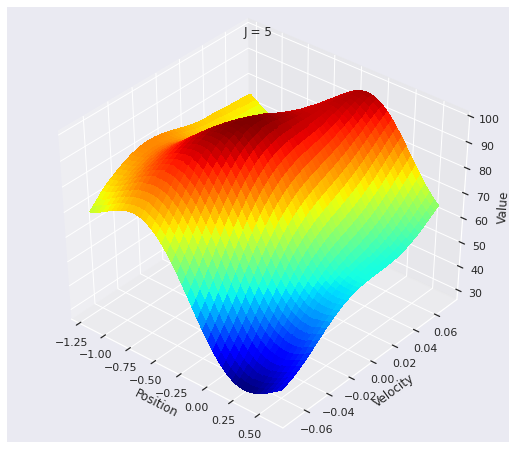

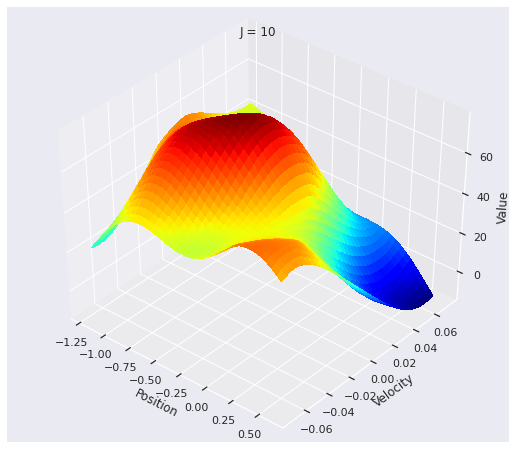

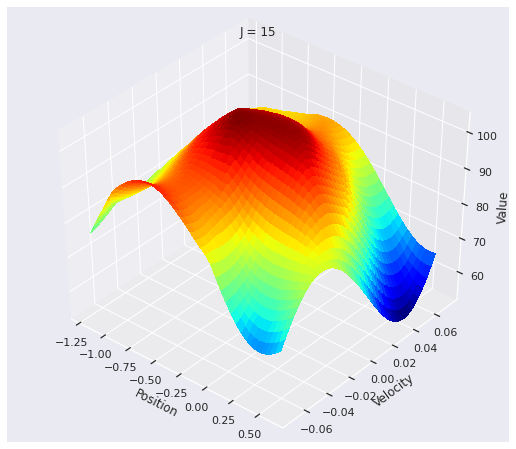

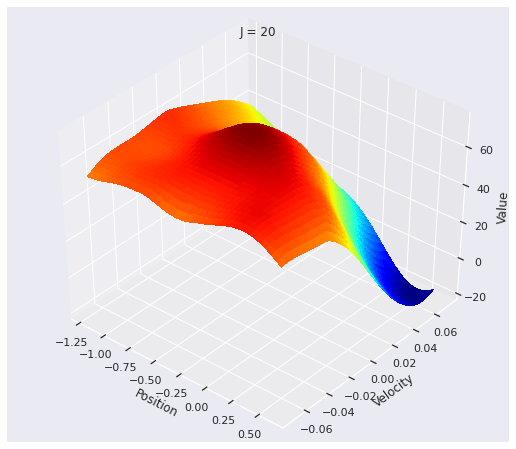

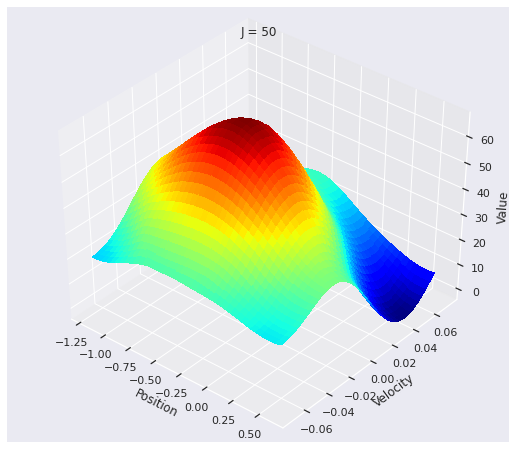

In [20]:
X = np.dstack([pos_grid, vel_grid]).reshape(-1, 2)
print(X.shape)

J_list = [5, 10, 15, 20, 50]
rbf_steps = []
rbf_mse = []
for i, q_function in enumerate(q_functions[:, 0]):
# for J in [5, 15, 20]:
    
    Q_hat, V_hat = rbf_approximation(X, q_function)
    rbf_mse.append(mean_squared_error(V, V_hat)) # track mse
    average_steps = np.mean([evaluate_Q(q_function) for _ in range(5)]) # take average due to stochasticity
    rbf_steps.append(average_steps) # track episode length

    J = J_list[i]
    fig = plot_value_func(pos_grid, vel_grid, V_hat, J)
    fig.savefig(f"func_approx_sarsa_value_func_{J}.pdf")

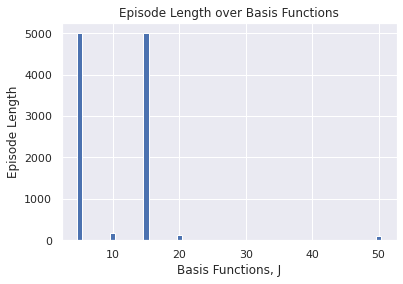

In [29]:
fig, ax = plt.subplots()
ax.bar(J_list, rbf_steps)
ax.set(xlabel="Basis Functions, J", ylabel="Episode Length", title="Episode Length over Basis Functions")
fig.savefig("ep_steps_j.pdf")

In [30]:
print(rbf_steps[1])

167.2


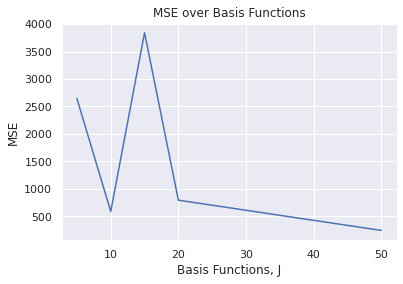

In [19]:
fig, ax = plt.subplots()
ax.plot(J_list, rbf_mse)
# ax.set_yscale('symlog')
ax.set(xlabel="Basis Functions, J", ylabel="MSE", title="MSE over Basis Functions")
fig.savefig("mse_j.pdf")

In [28]:
rbf_mse[1]

590.2387987529816

In [11]:
while True:pass


KeyboardInterrupt: ignored